# Section 1: Cleaning the Data

In [296]:
# Imports
import pandas as pd
from IPython.display import display
from sklearn.preprocessing import MinMaxScaler

import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, cross_val_score, cross_val_predict
from sklearn.neighbors import KNeighborsClassifier

# Decision Tree for comparison
from sklearn.tree import DecisionTreeClassifier

Load the dataset from a file to a dataframe. Drop any attributes with irrelevant data.

In [297]:
# Load the data file
df = pd.read_csv("./ford.csv")

# drop unecessary columns
df = df.drop(["tax"], axis=1)

# Drop impossible years
mask = df.year > 2022
index = df.loc[mask].index
df = df.drop(index=index, axis=1)

# Cars must have a valid engine size if they are Diesel or Petrol
mask = (df.engineSize == 0.0)
mask = mask & ( (df.fuelType == 'Diesel') | (df.fuelType == 'Petrol') )
index = df.loc[mask].index
df = df.drop(index=index, axis=1)

# drop records with ambiguous fuel type
mask = (df.fuelType == "Other")
index = df.loc[mask].index
df = df.drop(index=index, axis=1)

print(df.shape)



(17913, 8)


In [298]:
models = df.model.unique()
fuelTypes = df.fuelType.unique()
transmissions = df.transmission.unique()
engineSizes = df.engineSize.unique()

print("Models\n", models,
      "\n\nFuel Types\n", fuelTypes,
      "\n\nTransmissions\n", transmissions,
      "\n\nEngine Sizes\n", engineSizes)

Models
 [' Fiesta' ' Focus' ' Puma' ' Kuga' ' EcoSport' ' C-MAX' ' Mondeo' ' Ka+'
 ' Tourneo Custom' ' S-MAX' ' B-MAX' ' Edge' ' Tourneo Connect'
 ' Grand C-MAX' ' KA' ' Galaxy' ' Mustang' ' Grand Tourneo Connect'
 ' Fusion' ' Ranger' ' Streetka' ' Escort' ' Transit Tourneo'] 

Fuel Types
 ['Petrol' 'Diesel' 'Hybrid' 'Electric'] 

Transmissions
 ['Automatic' 'Manual' 'Semi-Auto'] 

Engine Sizes
 [1.  1.5 1.6 1.2 2.  1.1 2.3 1.4 5.  2.2 2.5 1.8 1.3 3.2 0.  1.7]


### Convert categorical data to numeric format
The target feature is car model. Encode the categorical features as 0 or 1 using `pandas.get_dummies()`. Leave the target feature unchanged.

In [299]:
print(df.dtypes)

model            object
year              int64
price             int64
transmission     object
mileage           int64
fuelType         object
mpg             float64
engineSize      float64
dtype: object


In [300]:
transmissionNumeric = pd.get_dummies(df.transmission)
df = pd.concat([df.drop("transmission", axis=1), transmissionNumeric], axis=1)
fuelTypeNumeric = pd.get_dummies(df.fuelType)
df = pd.concat([df.drop("fuelType", axis=1), fuelTypeNumeric], axis=1)
display(df.head())
df.to_csv("clean_Ford.csv", index=False)

,model,year,price,mileage,mpg,engineSize,Automatic,Manual,Semi-Auto,Diesel,Electric,Hybrid,Petrol
0,Fiesta,2017,12000,15944,57.7,1.0,1,0,0,0,0,0,1
1,Focus,2018,14000,9083,57.7,1.0,0,1,0,0,0,0,1
2,Focus,2017,13000,12456,57.7,1.0,0,1,0,0,0,0,1
3,Fiesta,2019,17500,10460,40.3,1.5,0,1,0,0,0,0,1
4,Fiesta,2019,16500,1482,48.7,1.0,1,0,0,0,0,0,1


<!-- ### Drop attributes or records to fine-tune the KNN model

A KNN model on the full dataset yields a high misclassification rate for certain cars such as the "Tourneo Connect" and the "Fusion" models. The cars with higher misclassification rates will isolated to a separate KNN model to study the behavior related to the high misclassification rates.

The primary dataset to be examined is stored to `df` and is exported to the "clean1_Ford.csv" file. 

The car models with high misclassification rates are stored in `df2` and exported to the "clean2_Ford.csv" file. -->

---

# Section 2 : Scaling the Data

Scale the dataset. Additionaly, multiply the "mpg scaled" attribute by a weight of `mpg_weight` to adjust the impact for groupings of this attribute.

In [301]:
df = pd.read_csv("clean_Ford.csv")

In [302]:
mpg_weight = 7.0

# use mpg_col_name to rename the columns after adjusting the "mpg scaled" feature
mpg_col_name = "mpg scaled * " + str(mpg_weight)
print("mpg_col_name: '" + mpg_col_name + "'")

mpg_col_name: 'mpg scaled * 7.0'


In [303]:
scaler = MinMaxScaler()
X = df.drop("model", axis=1)
scaler.fit(X)
X_scaled = scaler.transform(X)
X.columns = X.columns + " scaled"
X_scaled = pd.DataFrame(X_scaled, columns=X.columns)

In [304]:
# adjust the 'mpg scaled' feature
mpg_scaled = X_scaled["mpg scaled"].to_frame(name=mpg_col_name)*mpg_weight
X_scaled = pd.concat([X_scaled.drop("mpg scaled", axis=1), mpg_scaled], axis=1)
display(X_scaled.head())

,year scaled,price scaled,mileage scaled,engineSize scaled,Automatic scaled,Manual scaled,Semi-Auto scaled,Diesel scaled,Electric scaled,Hybrid scaled,Petrol scaled,mpg scaled * 7.0
0,0.875000,0.211101,0.089747,0.2,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.427072
1,0.916667,0.247798,0.051125,0.2,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.427072
2,0.875000,0.229450,0.070113,0.2,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.427072
3,0.958333,0.312018,0.058877,0.3,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.754144
4,0.958333,0.293670,0.008337,0.2,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.079006


In [305]:
X_scaled.to_csv("X_scaled.csv", index=False)
df.model.to_csv("y.csv", index=False)

---

# Section 3: Designing the KNN Model

Read the scaled data from files. Store the features and targets to variables. These variables will be used for train-test splitting.

In [306]:
# read scaled data for non-target attributes
X_scaled = pd.read_csv("X_scaled.csv")

# read the target attribute
y = pd.read_csv("y.csv").to_numpy().ravel()

### study interactions

```python

# labels for pairwise plots
from sklearn.preprocessing._label import LabelEncoder

pd.plotting.scatter_matrix(
    X_scaled[X_scaled.columns[[0,1,2,3,11]]],
    c=LabelEncoder().fit(y).transform(y),
    hist_kwds={'bins':40},
    figsize=(11, 8.5),
)
plt.text(-17, 21000, "Primary Dataset\n  Pairwise Plots", size=20)
plt.show()
```
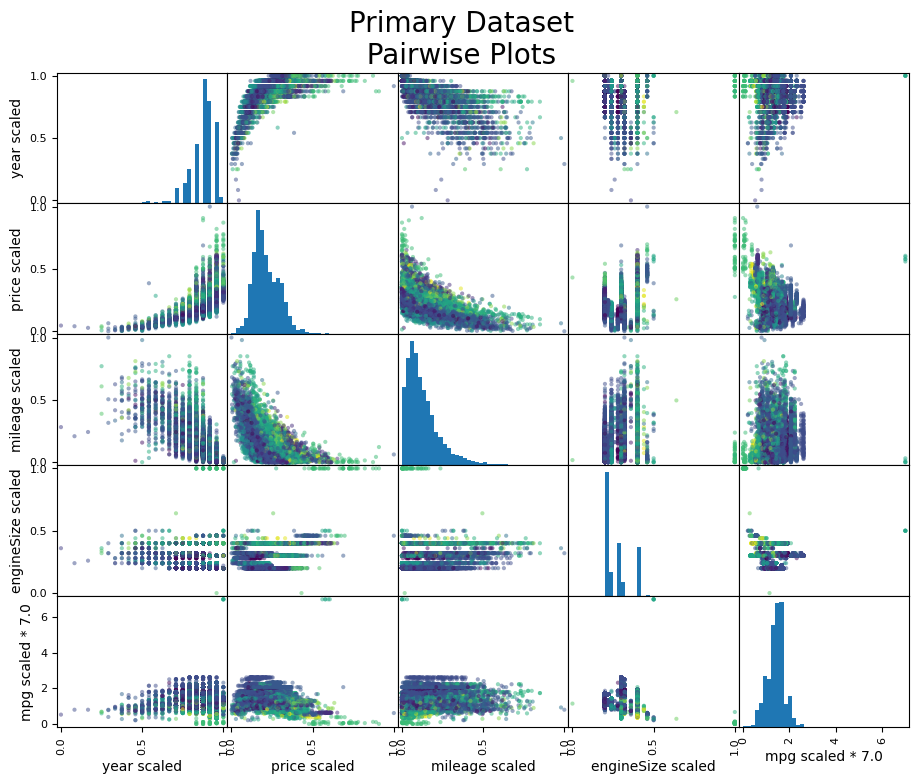


Divide data into training and test sets

In [307]:
X_train_scaled, X_test_scaled, y_train, y_test = train_test_split(
    X_scaled, y,
    random_state=0
)

--- 

# Section 4: Decision Tree Comparision

Create a decision tree and a KNN from the dataset and compare accuracies of each model

In [308]:
tree = DecisionTreeClassifier(
    # random_state=0
)
knn = KNeighborsClassifier()


# import the scaled data and split into training and test sets
X_train_scaled, X_test_scaled, y_train, y_test = train_test_split(
    pd.read_csv("X_scaled.csv"), 
    pd.read_csv("y.csv"), 
    random_state=0
)
y_train = np.ravel(y_train)
y_test = np.ravel(y_test)

tree.fit(X_train_scaled, y_train)
knn.fit(X_train_scaled, y_train)

# hacky way to clear the output
display() 

In [309]:
print("Primary Dataset, accuracies on the test set")
print("tree accuracy: " + str(tree.score(X_test_scaled, y_test)))
print("knn accuracy: " + str(knn.score(X_test_scaled, y_test)))

Primary Dataset, accuracies on the test set
tree accuracy: 0.9211877651261442
knn accuracy: 0.9133735208751954


Create a decision tree and a KNN from the secondary dataset and compare accuracies of each model

---

# Section 5: Cross Validation

Evaluate the accuracy of a 10-fold cross validation for the KNN model.

In [310]:
# features = pd.concat([X_scaled, X2_scaled], ignore_index=True, verify_integrity=True)
features = X_scaled

In [311]:
# target = pd.DataFrame(np.append(y, y2))
target = pd.DataFrame(y, columns=["model"])

In [312]:
models = target.model.unique().tolist()

In [313]:
indexes = np.empty(shape=0, dtype=np.uint16)

display(target.shape[0])

for model in models:
    mask = (target.model == model)
    if (target[mask].shape[0] <= 50):
        index = target[mask].index[:]
        print(model, "- remove", index.shape[0], "record(s)")
        indexes = np.append(indexes, index)

target = target.drop(index=indexes, axis=0)
features = features.drop(index=indexes, axis=0)

display(target.shape[0])

17913

 Tourneo Connect - remove 33 record(s)
 Fusion - remove 16 record(s)
 Ranger - remove 1 record(s)
 Streetka - remove 2 record(s)
 Escort - remove 1 record(s)
 Transit Tourneo - remove 1 record(s)


17859

In [314]:
models = target.model.unique().tolist()

In [315]:
print(models)

[' Fiesta', ' Focus', ' Puma', ' Kuga', ' EcoSport', ' C-MAX', ' Mondeo', ' Ka+', ' Tourneo Custom', ' S-MAX', ' B-MAX', ' Edge', ' Grand C-MAX', ' KA', ' Galaxy', ' Mustang', ' Grand Tourneo Connect']


In [316]:
target = target.to_numpy().ravel()

In [317]:
knn = KNeighborsClassifier()
cv = cross_val_score(knn, features, target, cv=10)

In [318]:
cv.mean()

0.9184125833984209

In [319]:
tree = DecisionTreeClassifier(
    # random_state=0
)

cv_tree = cross_val_score(tree, features, target, cv=10)
cv_tree.mean()

0.9228939056025546

---


# Accuracy Assessment on individual targets

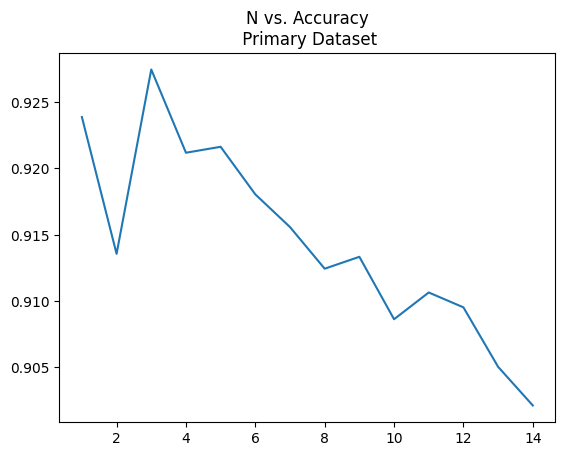

In [320]:
X_train_scaled, X_test_scaled, y_train, y_test = train_test_split(
    features, target,
    random_state=0
)

arr = np.array([])
y_test = y_test.squeeze()


for n in range(1,15):
    knn = KNeighborsClassifier(n_neighbors=n)
    knn.fit(X_train_scaled, y_train)
    y1_predict = knn.predict(X_test_scaled)
    m = np.mean(y1_predict == y_test)
    arr = np.append(arr, np.array(m))
plt.plot(range(1, arr.size+1), arr)
plt.title("N vs. Accuracy")
plt.show()

In [321]:
knn = KNeighborsClassifier(n_neighbors=3)
knn.fit(X_train_scaled, y_train)
y_predict = knn.predict(X_test_scaled)
m = np.mean(y_predict == y_test)
arr = np.append(arr, np.array(m))
display(knn.score(X_test_scaled, y_test))

0.9274356103023517

array([' Fiesta', ' C-MAX', ' KA', ' S-MAX', ' Kuga', ' Grand C-MAX',
       ' Puma', ' Mondeo', ' Mustang', ' Galaxy', ' B-MAX', ' Focus',
       ' Ka+', ' EcoSport', ' Edge', ' Grand Tourneo Connect',
       ' Tourneo Custom'], dtype=object)

(324,)

324

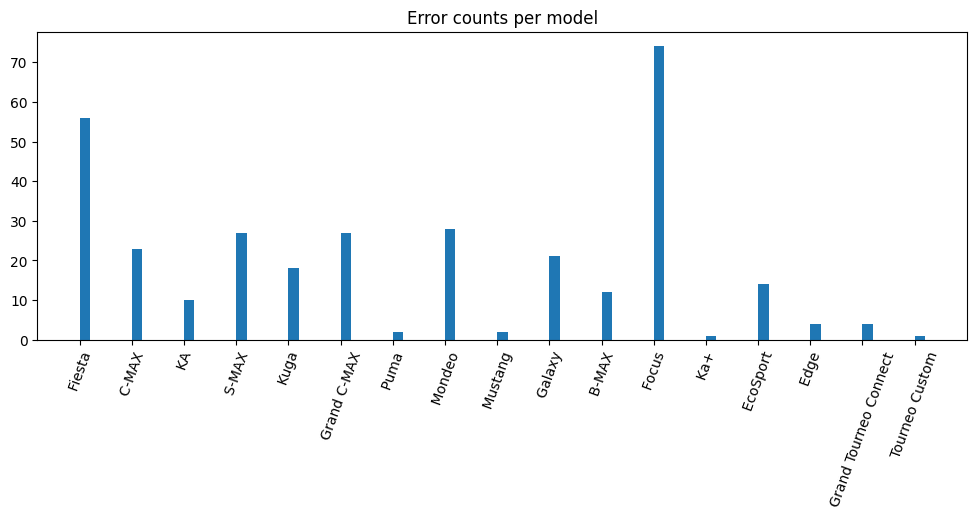

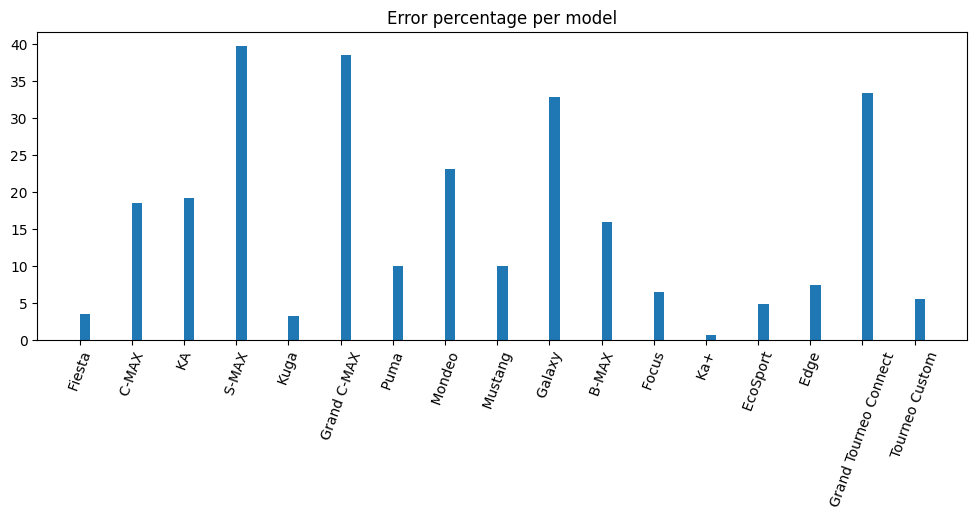

In [322]:
# misclassified_y = pd.DataFrame(y_test[y_test != y_predict], columns=["model"])

misclassified_y = y_test[y_test != y_predict]

names = pd.Series(misclassified_y).unique()
sum = 0
error_counts = np.array([])
name_counts = np.array([])
for name in names:
    errors = misclassified_y[misclassified_y == name].shape[0]
    sum += errors
    error_counts = np.append(error_counts, np.array(errors))
    name_total = y_test[y_test == name].shape[0]
    name_counts = np.append(name_counts, np.array(name_total))
display(names, misclassified_y.shape, sum)

error_percentage = 100 * error_counts / name_counts



# Plot misclassifications
plt.figure(figsize=(12, 4))
plt.bar(range(error_counts.size), height=error_counts, align='edge', width=0.2)
plt.xticks(range(error_counts.size), names, rotation=70)
plt.title("Error counts per model")
plt.show()

plt.figure(figsize=(12, 4))
plt.bar(range(error_counts.size), height=error_percentage, align='edge', width=0.2)
plt.xticks(range(error_counts.size), names, rotation=70)
plt.title("Error percentage per model")
plt.show()